Load MNIST Data from TorchVision

*TODO: make this part torch independent*

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms

image_path = './'
transform = transforms.Compose([
    transforms.ToTensor()
])

mnist_dataset = torchvision.datasets.MNIST(
    root=image_path, train=True, transform = transform, download=True
)

from torch.utils.data import Subset
mnist_valid_dataset = Subset(mnist_dataset,
                             torch.arange(10000))
mnist_train_dataset = Subset (mnist_dataset,
                              torch.arange(
                                  10000, len (mnist_dataset)
                                  ))
mnist_test_dataset = torchvision.datasets.MNIST(root=image_path, train = False,
                                                transform=transform, download = False
                                                )


construct the data loader with batches of 64 images

In [2]:
from torch.utils.data import DataLoader
batch_size = 64
torch.manual_seed(1)
train_dl = DataLoader(mnist_train_dataset,
                      batch_size,
                      shuffle=True)
valid_dl = DataLoader(mnist_valid_dataset,
                      batch_size,
                      shuffle=False)


construct the model (1st part)


In [3]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
device = 'cuda' if torch.cuda.is_available() else 'cpu'


1
NVIDIA GeForce GTX 1060 6GB


In [4]:
model = nn.Sequential()
model.add_module(
    'conv1',
    nn.Conv2d(
        in_channels=1, out_channels=32,
        kernel_size=5, padding=2
    )
)
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))
model.add_module(
    'conv2',
    nn.Conv2d(
        in_channels=32, out_channels=64,
        kernel_size=5, padding=2
    )
)
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))


we added 2 conv layers 5x5 padding 2

The spatial dimension of the output feature map is calculated by
$$
o = \left\lfloor\frac{n + 2p -m}{s}\right\rfloor +1
$$
---

use torch to calculate the size of the feature maps




In [5]:
x = torch.ones((4,1,28,28))
model(x).shape

torch.Size([4, 64, 7, 7])

Add the fully connected layer (torch Linear), but first first flatten the features


In [6]:
model.add_module('flatten', nn.Flatten())
x = torch.ones((4,1,28,28))
model(x).shape

torch.Size([4, 3136])

In [7]:
model.add_module('fc1', nn.Linear(3136, 1024))
model.add_module('relu3', nn.ReLU())
model.add_module('dropout', nn.Dropout(p=0.5))
model.add_module('fc2', nn.Linear(1024,10))

No need to add explicitly softmax for the fully connected layer because CrossEntropyLoss uses it internally

AAA: loss must be passed to device

In [8]:
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


Adam is robust, gradient-based, suited to nonconvex optimization and machine learning inspired by **RMSProp** and **AdaGrad**.
Key advantage: update step size based on running average of gradient moments.
Diederik P. Kingma and Jimmy Le Ba - *Adam: A Method for Stochastic Optimization* - 2014 -`https://arxiv/org/abs/1412/6980`





train code

*The item() method extracts the loss’s value as a Python float.*


In [9]:
def train(model, num_epochs, train_dl, valid_dl):
  loss_hist_train = [0] * num_epochs
  accuracy_hist_train = [0] * num_epochs
  loss_hist_valid = [0] * num_epochs
  accuracy_hist_valid = [0] * num_epochs
  for epoch in range(num_epochs):
    model.train()
    for x_batch, y_batch in train_dl:
      #GF_added  (but may be I'm missing something here)
      x_batch, y_batch = x_batch.to(device), y_batch.to(device)
      pred = model(x_batch)
      loss = loss_fn(pred, y_batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      loss_hist_train[epoch] += loss.item()*y_batch.size(0)
      is_correct = (
          torch.argmax(pred, dim=1) == y_batch
      ).float()
      accuracy_hist_train[epoch] += is_correct.sum()
    loss_hist_train[epoch] /= len(train_dl.dataset)
    accuracy_hist_train[epoch] /= len(train_dl.dataset)

    model.eval()

    with torch.no_grad():
      for x_batch, y_batch in valid_dl:
        #GF_added (but may be I'm missing something here)
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch)
        loss_hist_valid[epoch] += \
          loss.item()*y_batch.size(0)
        is_correct = (
            torch.argmax(pred, dim=1) == y_batch
        ).float()
        accuracy_hist_valid[epoch] += is_correct.sum()
    loss_hist_valid[epoch] /= len(valid_dl.dataset)
    accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

    print(f'Epoch {epoch+1} accuracy: '
          f'{accuracy_hist_train[epoch]:.4f} val_accuracy '
          f'{accuracy_hist_valid[epoch]:.4f}')
  return loss_hist_train, loss_hist_valid, \
          accuracy_hist_train, accuracy_hist_valid



train the model


select device

In [10]:
model.to(device)

Sequential(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3136, out_features=1024, bias=True)
  (relu3): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)

In [11]:
torch.manual_seed(1)
num_epochs = 20
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.9503 val_accuracy 0.9813
Epoch 2 accuracy: 0.9838 val_accuracy 0.9880
Epoch 3 accuracy: 0.9898 val_accuracy 0.9845
Epoch 4 accuracy: 0.9919 val_accuracy 0.9908
Epoch 5 accuracy: 0.9929 val_accuracy 0.9897
Epoch 6 accuracy: 0.9953 val_accuracy 0.9901
Epoch 7 accuracy: 0.9954 val_accuracy 0.9912
Epoch 8 accuracy: 0.9956 val_accuracy 0.9884
Epoch 9 accuracy: 0.9953 val_accuracy 0.9885
Epoch 10 accuracy: 0.9971 val_accuracy 0.9907
Epoch 11 accuracy: 0.9971 val_accuracy 0.9904
Epoch 12 accuracy: 0.9975 val_accuracy 0.9896
Epoch 13 accuracy: 0.9972 val_accuracy 0.9908
Epoch 14 accuracy: 0.9975 val_accuracy 0.9911
Epoch 15 accuracy: 0.9974 val_accuracy 0.9915
Epoch 16 accuracy: 0.9985 val_accuracy 0.9915
Epoch 17 accuracy: 0.9981 val_accuracy 0.9891
Epoch 18 accuracy: 0.9973 val_accuracy 0.9904
Epoch 19 accuracy: 0.9985 val_accuracy 0.9910
Epoch 20 accuracy: 0.9985 val_accuracy 0.9900


Evaluation

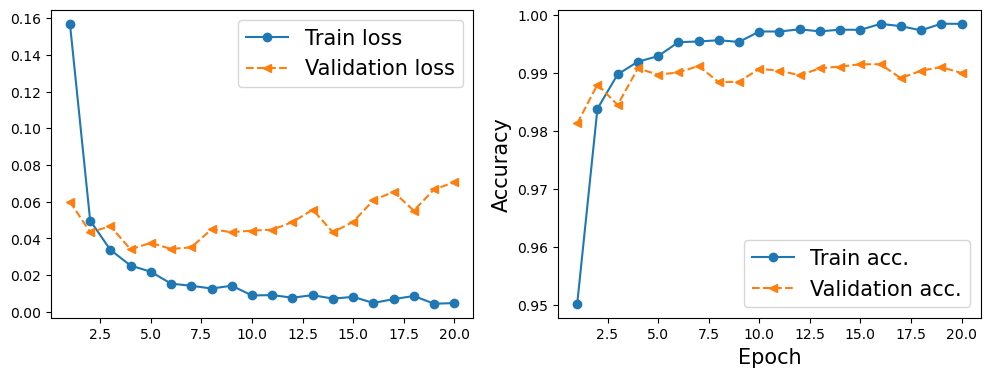

In [12]:
import numpy as np
import matplotlib.pyplot as plt
x_arr = np.arange(len(hist[0]))+1
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, [x.cpu() for x in hist[2]], '-o', label='Train acc.')
ax.plot(x_arr, [x.cpu() for x in hist[3]], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()


Evaluate on test dataset

In [13]:
import time
start_time = time.time()
test_device = 'cuda'
model.to(test_device)
print(mnist_test_dataset.data.size())
pred = model(mnist_test_dataset.data.unsqueeze(1).to(test_device) / 255.)
is_correct = (
    torch.argmax(pred, dim=1) == mnist_test_dataset.targets.to(test_device)
).float()
print(f'Test accuracy: {is_correct.mean():.4f}')
cuda_time = time.time() - start_time
print(f'--- %s seconds --- {cuda_time:.4f}')



torch.Size([10000, 28, 28])
Test accuracy: 0.9906
--- %s seconds --- 0.5665


In [14]:
import time
start_time = time.time()
test_device = 'cpu'
model.to(test_device)
print(mnist_test_dataset.data.size())
pred = model(mnist_test_dataset.data.unsqueeze(1).to(test_device) / 255.)
is_correct = (
    torch.argmax(pred, dim=1) == mnist_test_dataset.targets.to(test_device)
).float()
print(f'Test accuracy: {is_correct.mean():.4f}')
cpu_time = time.time() - start_time
print(f'--- %s seconds --- {cpu_time:.4f}')

print(f'cuda is {cpu_time/cuda_time:.4f} faster')

torch.Size([10000, 28, 28])
Test accuracy: 0.9906
--- %s seconds --- 3.4530
cuda is 6.0951 faster


class membership probabilities and convert to predicted labels using argmax


tensor([[-20.5337, -16.3832, -23.0266, -22.3314, -15.9990, -23.7557, -39.9924,
          31.6599, -24.6549, -10.4846]], grad_fn=<AddmmBackward0>)
tensor([[ -2.0950,  -8.9690,  24.2769, -16.2549,  -9.2118, -26.6687, -12.0636,
         -18.7114, -12.9437, -20.2243]], grad_fn=<AddmmBackward0>)
tensor([[-25.1136,  31.7909, -26.8321, -27.1514, -13.3905, -14.7026, -16.9655,
          -9.4859, -22.8993, -28.6826]], grad_fn=<AddmmBackward0>)
tensor([[ 33.1928, -21.1250, -13.7154, -29.8746, -18.1430, -17.9610, -15.9513,
         -16.7865, -12.6421, -16.0715]], grad_fn=<AddmmBackward0>)
tensor([[-15.7921, -12.6925, -12.5787, -31.4042,  26.1632, -13.0504, -15.9628,
         -10.6620, -17.4261, -14.4998]], grad_fn=<AddmmBackward0>)
tensor([[-23.2189,  33.7285, -24.9740, -30.1132, -14.8948, -21.3144, -20.4907,
          -8.2719, -25.6624, -28.6609]], grad_fn=<AddmmBackward0>)
tensor([[-19.2674,  -6.3641, -12.6814, -26.9064,  18.1130, -13.1158, -13.2532,
          -5.6761,  -3.2130, -15.5739]], grad

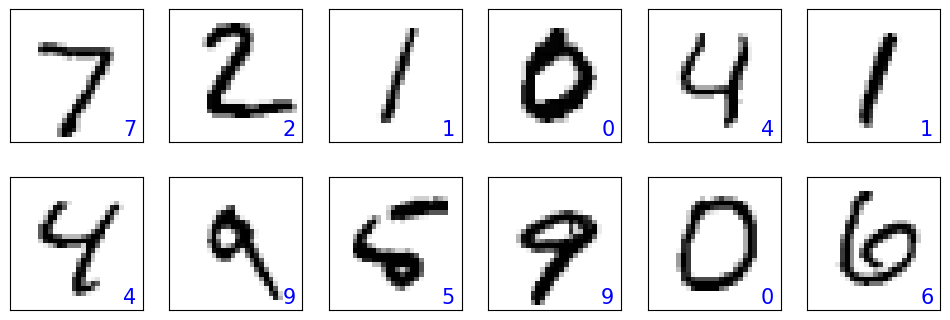

In [15]:
test_device = 'cpu'
model.to(test_device)
fig = plt.figure(figsize=(12,4))
for i in range(12):
  ax = fig.add_subplot(2,6, i+1)
  ax.set_xticks([]); ax.set_yticks([])
  img = mnist_test_dataset[i][0][0,:,:]
  pred = model(img.unsqueeze(0).unsqueeze(1).to(test_device))
  print(pred)
  y_pred = torch.argmax(pred)
  ax.imshow(img, cmap = 'gray_r')
  ax.text(0.9,0.1,y_pred.item(),
          size=15, color='blue',
          horizontalalignment='center',
          verticalalignment='center',
          transform=ax.transAxes)

plt.show()


TODO: find misclassified digits and print them out